In [1]:
import pandas as pd
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

#import albumentations as A
#from albumentations.pytorch import ToTensorV2

import cv2

from tqdm import tqdm
from PIL import Image

%matplotlib inline

# Split sets exploration

In [2]:
database1_source = ['global-bird-zenodo_poland', 'global-bird-zenodo_palmyra', 'global-bird-zenodo_penguins',
                    'global-bird-zenodo_mckellar', 'global-bird-zenodo_pfeifer', 'uav-waterfowl-thermal']

database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/all_datasets_10percent_background'

with open(os.path.join(database_folder, 'data_stats.yaml'), "r") as yamlfile:
    stats = yaml.load(yamlfile, Loader=yaml.FullLoader)

In [3]:
stats

{'global-bird-zenodo_mckellar': {'Test': {'birds_repartition': {1: 58,
    2: 15,
    3: 10,
    4: 2,
    5: 1,
    9: 1,
    10: 1},
   'nb_birds': 150,
   'nb_img': 104},
  'Train': {'birds_repartition': {1: 277,
    2: 132,
    3: 98,
    4: 69,
    5: 40,
    6: 33,
    7: 24,
    8: 18,
    9: 7,
    10: 5,
    11: 3,
    12: 3,
    13: 1,
    14: 1,
    15: 1,
    24: 2},
   'nb_birds': 2093,
   'nb_img': 784},
  'Val': {'birds_repartition': {1: 66, 2: 6, 4: 2},
   'nb_birds': 86,
   'nb_img': 86},
  'name': 'global_birds_mckellar'},
 'global-bird-zenodo_palmyra': {'Test': {'birds_repartition': {1: 217,
    2: 54,
    3: 24,
    4: 8,
    5: 4,
    6: 2},
   'nb_birds': 461,
   'nb_img': 352},
  'Train': {'birds_repartition': {1: 671,
    2: 215,
    3: 93,
    4: 33,
    5: 23,
    6: 16,
    7: 7,
    8: 4,
    9: 3,
    10: 3,
    11: 4,
    12: 3,
    13: 2,
    15: 1,
    16: 1,
    17: 5,
    19: 1,
    20: 1,
    21: 2,
    27: 3,
    28: 1,
    31: 1,
    33: 2,
    58: 

nb of backgruond img in dataset:  95


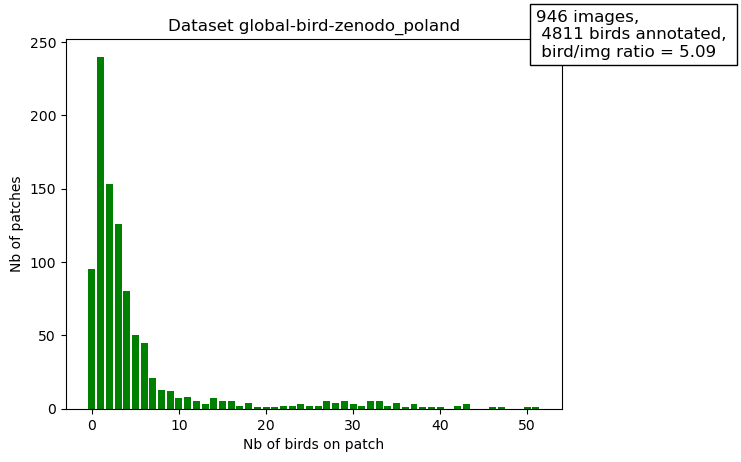

nb of backgruond img in dataset:  175


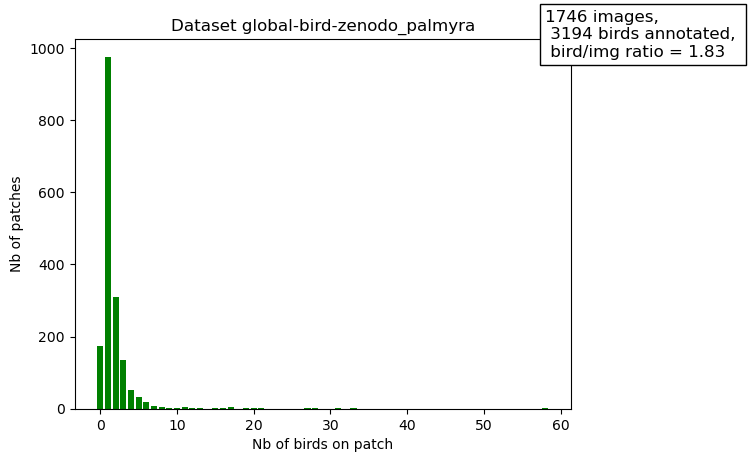

nb of backgruond img in dataset:  78


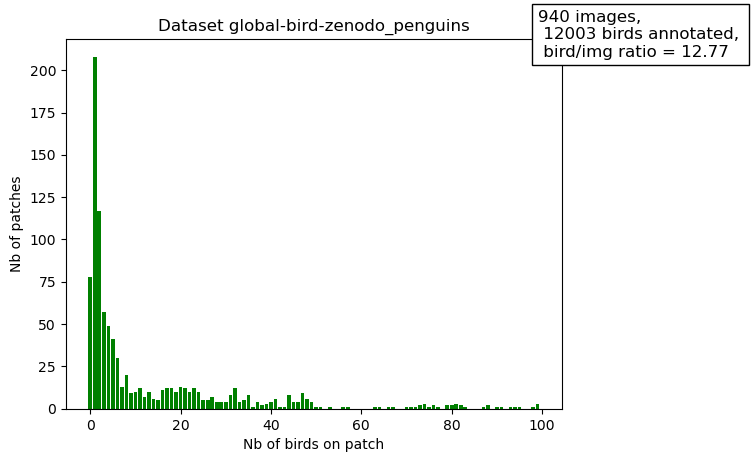

nb of backgruond img in dataset:  98


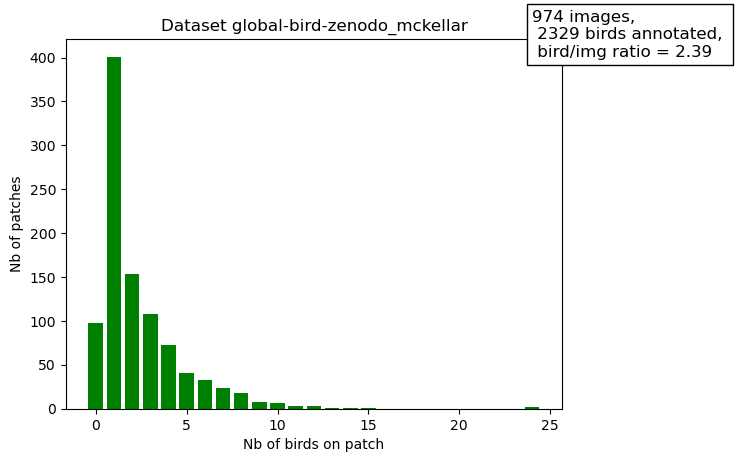

nb of backgruond img in dataset:  335


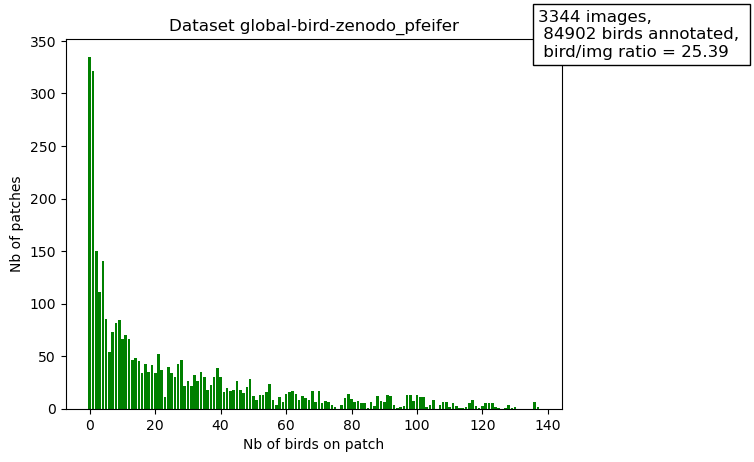

nb of backgruond img in dataset:  78


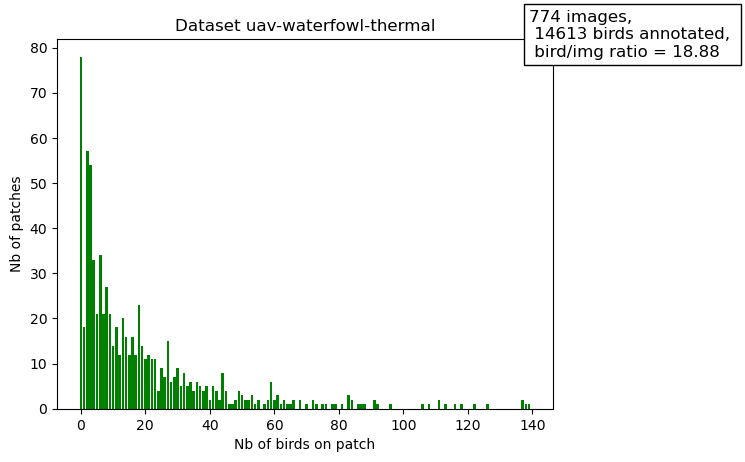

Nb of background images:  859
Total nb of images:  8724


In [4]:
from collections import Counter

total_nb_bckgd_img = 0 
total_nb_img = 0 

for dataset in database1_source:

    dataset_stats = stats[dataset]

    birds_repartition = z = dict(Counter(dataset_stats['Train']['birds_repartition']) + Counter(dataset_stats['Val']['birds_repartition']) + Counter(dataset_stats['Test']['birds_repartition']))
    nb_birds = dataset_stats['Train']['nb_birds'] + dataset_stats['Val']['nb_birds'] + dataset_stats['Test']['nb_birds']
    nb_img = dataset_stats['Train']['nb_img'] + dataset_stats['Val']['nb_img'] + dataset_stats['Test']['nb_img']
    nb_background_img = nb_img - sum(birds_repartition.values())
    print("nb of backgruond img in dataset: ", nb_background_img)
    total_nb_bckgd_img += nb_background_img
    total_nb_img += nb_img
    birds_repartition[0] = nb_background_img
    bird_img_ratio = nb_birds/nb_img

    plt.bar(list(birds_repartition.keys()), birds_repartition.values(), color='g')
    plt.title(f'Dataset {dataset}')
    plt.text(max(birds_repartition.keys()), max(birds_repartition.values()), f"{nb_img} images, \n {nb_birds} birds annotated, \n bird/img ratio = {str(round(bird_img_ratio, 2))} ", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
    plt.xlabel('Nb of birds on patch')
    plt.ylabel('Nb of patches')
    plt.show()
    #plt.savefig(os.path.join(exploration_folder, f"stat_{dataset}_split_{split}.png"))

print("Nb of background images: ", total_nb_bckgd_img)
print("Total nb of images: ", total_nb_img)

{1: 149, 2: 104, 3: 72, 4: 62, 5: 40, 6: 32, 7: 16, 8: 8, 9: 7, 10: 4, 11: 6, 12: 3, 13: 1, 14: 5, 15: 2, 16: 1, 18: 1, 20: 1, 21: 1, 22: 2, 24: 3, 25: 2, 26: 2, 27: 5, 28: 4, 29: 5, 30: 3, 31: 2, 32: 5, 33: 5, 34: 2, 35: 4, 36: 1, 37: 3, 38: 1, 39: 1, 40: 1, 42: 2, 43: 3, 46: 1, 47: 1, 50: 1, 51: 1}
643 575
nb of backgruond img in split:  68


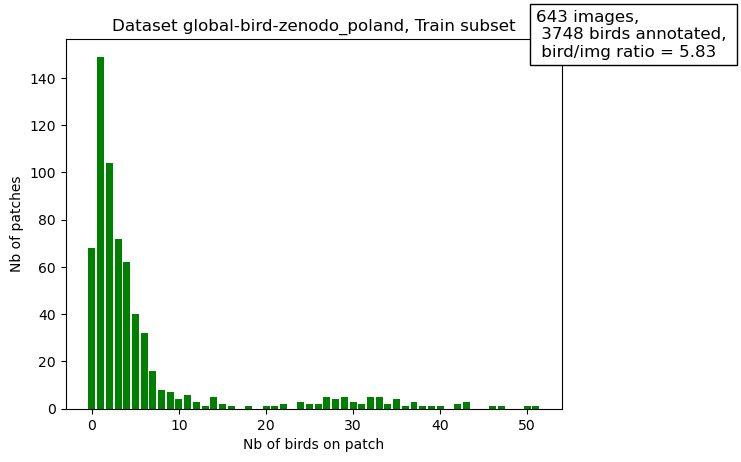

{1: 27, 2: 24, 3: 24, 4: 7, 5: 5, 6: 8, 7: 1, 8: 1}
104 97
nb of backgruond img in split:  7


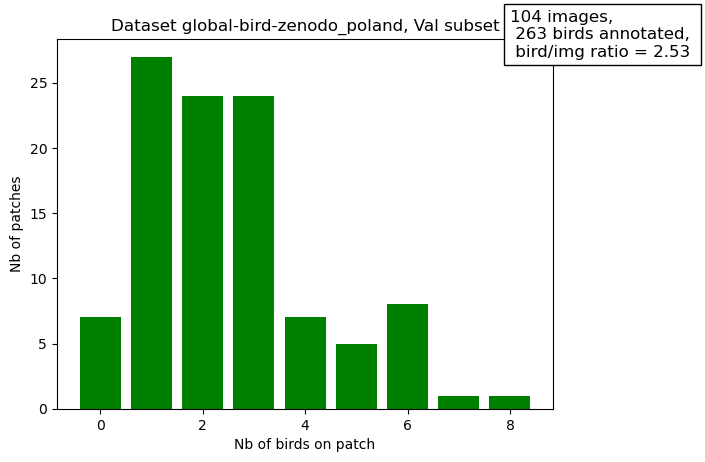

{1: 64, 2: 25, 3: 30, 4: 11, 5: 5, 6: 5, 7: 4, 8: 4, 9: 5, 10: 3, 11: 2, 12: 2, 13: 2, 14: 2, 15: 3, 16: 4, 17: 2, 18: 3, 19: 1, 23: 2}
199 179
nb of backgruond img in split:  20


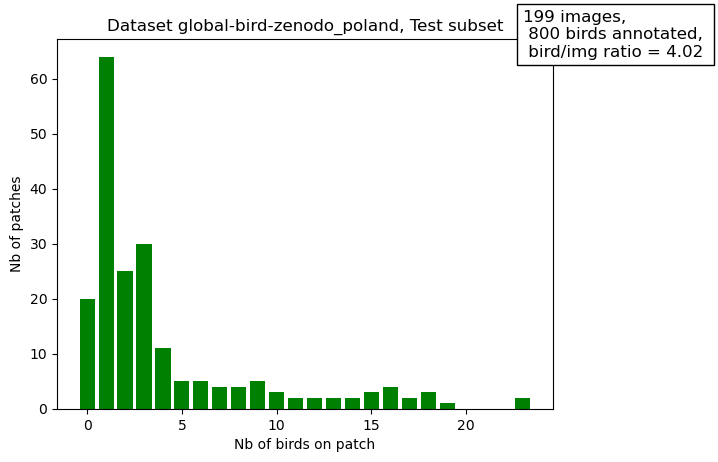

{1: 671, 2: 215, 3: 93, 4: 33, 5: 23, 6: 16, 7: 7, 8: 4, 9: 3, 10: 3, 11: 4, 12: 3, 13: 2, 15: 1, 16: 1, 17: 5, 19: 1, 20: 1, 21: 2, 27: 3, 28: 1, 31: 1, 33: 2, 58: 1}
1206 1096
nb of backgruond img in split:  110


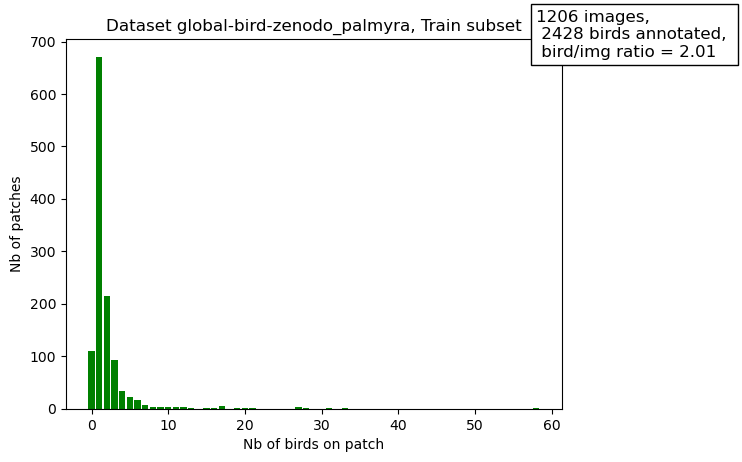

{1: 88, 2: 41, 3: 19, 4: 12, 5: 6}
188 166
nb of backgruond img in split:  22


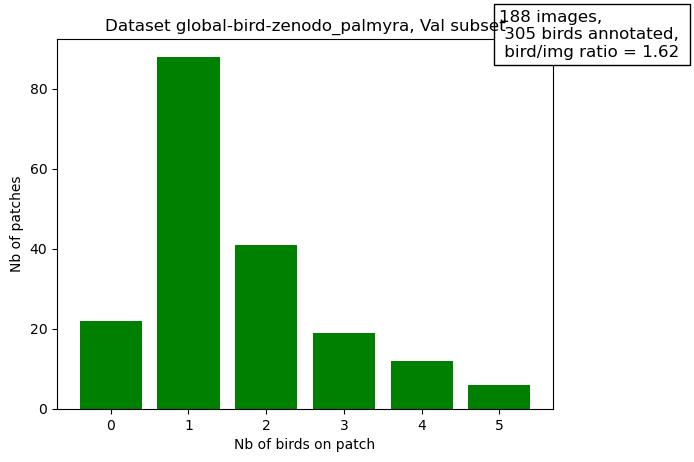

{1: 217, 2: 54, 3: 24, 4: 8, 5: 4, 6: 2}
352 309
nb of backgruond img in split:  43


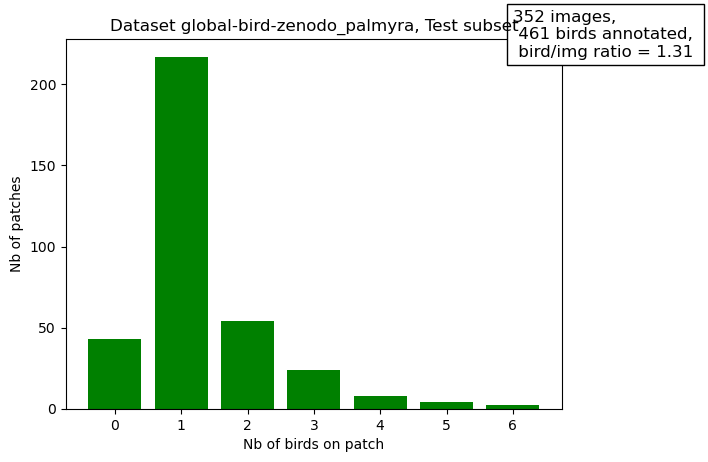

{1: 155, 2: 73, 3: 40, 4: 37, 5: 37, 6: 26, 7: 13, 8: 20, 9: 4, 10: 7, 11: 10, 12: 5, 13: 7, 14: 6, 15: 5, 16: 10, 17: 11, 18: 8, 19: 9, 20: 10, 21: 11, 22: 6, 23: 11, 24: 6, 25: 5, 26: 4, 27: 4, 28: 4, 29: 3, 30: 2, 31: 8, 32: 12, 33: 4, 34: 5, 35: 8, 36: 1, 37: 4, 38: 2, 39: 3, 40: 4, 41: 2, 43: 1, 44: 7, 45: 2, 46: 2, 47: 5, 48: 4, 49: 2, 50: 1}
688 626
nb of backgruond img in split:  62


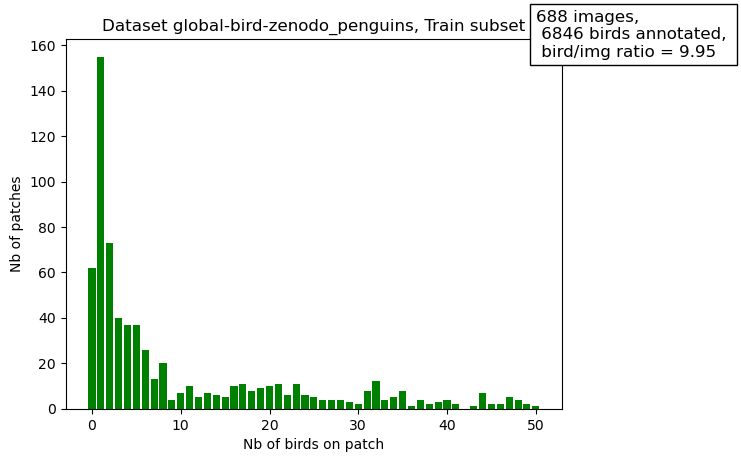

{1: 8, 2: 24, 3: 12, 4: 6, 5: 2, 6: 2, 9: 4, 18: 4, 21: 1, 22: 4, 24: 1, 26: 1, 29: 1, 66: 1, 67: 1, 71: 1, 74: 1, 76: 1, 77: 1, 79: 1, 80: 1, 81: 2, 82: 1, 83: 1}
84 82
nb of backgruond img in split:  2


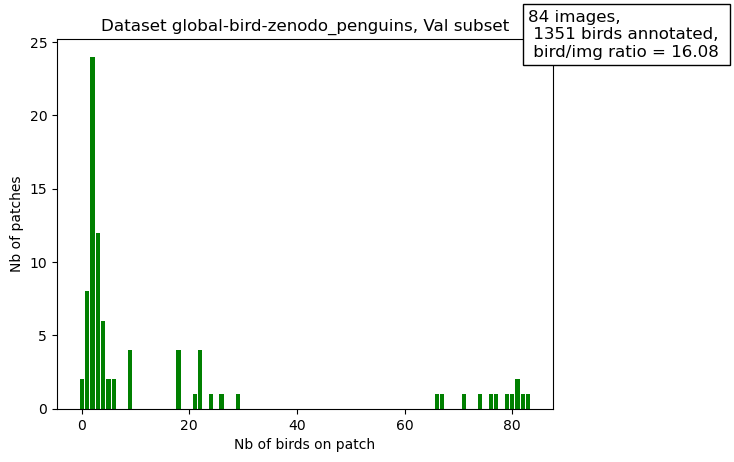

{1: 45, 2: 20, 3: 5, 4: 6, 5: 2, 6: 2, 9: 1, 10: 3, 11: 2, 12: 2, 13: 3, 16: 1, 17: 1, 19: 1, 20: 3, 23: 1, 24: 3, 27: 3, 30: 2, 41: 4, 42: 1, 44: 1, 45: 2, 46: 2, 47: 4, 48: 2, 49: 2, 51: 1, 53: 1, 56: 1, 57: 1, 63: 1, 64: 1, 70: 1, 72: 1, 73: 2, 74: 2, 75: 1, 76: 1, 79: 1, 80: 1, 81: 1, 82: 1, 87: 1, 88: 2, 90: 1, 91: 1, 93: 1, 94: 1, 95: 1, 98: 1, 99: 3}
168 154
nb of backgruond img in split:  14


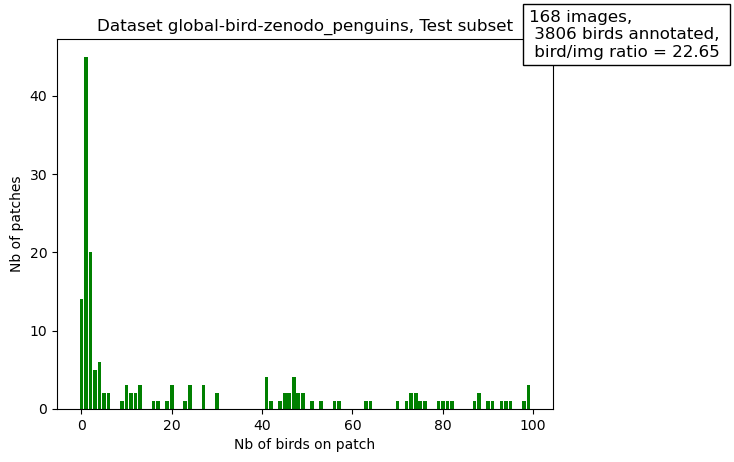

{1: 277, 2: 132, 3: 98, 4: 69, 5: 40, 6: 33, 7: 24, 8: 18, 9: 7, 10: 5, 11: 3, 12: 3, 13: 1, 14: 1, 15: 1, 24: 2}
784 714
nb of backgruond img in split:  70


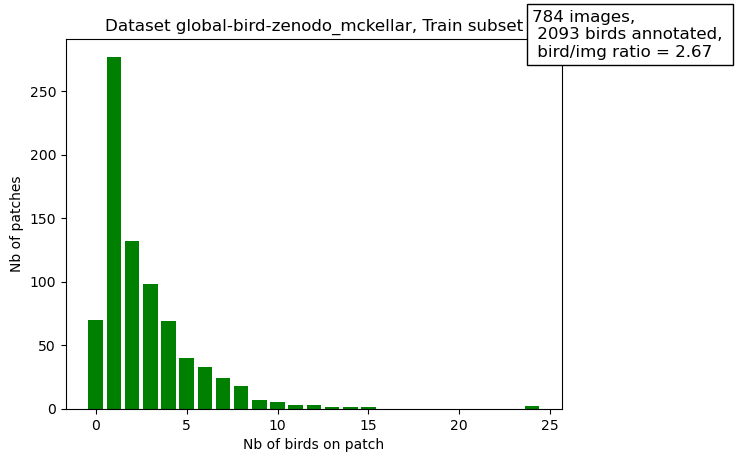

{1: 66, 2: 6, 4: 2}
86 74
nb of backgruond img in split:  12


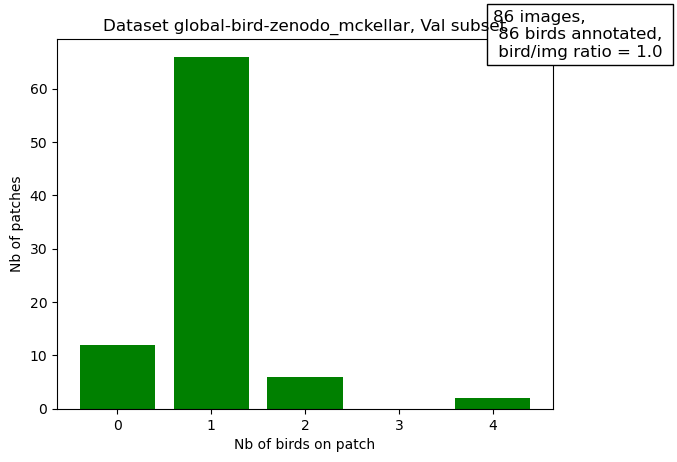

{1: 58, 2: 15, 3: 10, 4: 2, 5: 1, 9: 1, 10: 1}
104 88
nb of backgruond img in split:  16


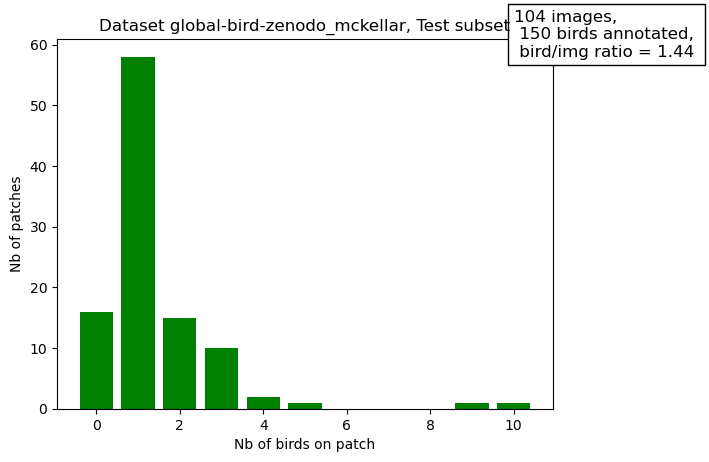

{1: 206, 2: 92, 3: 65, 4: 82, 5: 60, 6: 42, 7: 43, 8: 58, 9: 58, 10: 38, 11: 50, 12: 44, 13: 37, 14: 30, 15: 35, 16: 25, 17: 33, 18: 24, 19: 39, 20: 22, 21: 21, 22: 34, 23: 7, 24: 34, 25: 27, 26: 28, 27: 28, 28: 32, 29: 20, 30: 20, 31: 18, 32: 28, 33: 16, 34: 33, 35: 22, 36: 14, 37: 19, 38: 28, 39: 36, 40: 18, 41: 7, 42: 14, 43: 15, 44: 12, 45: 26, 46: 14, 47: 7, 48: 19, 49: 26, 50: 8, 51: 8, 52: 9, 53: 13, 54: 16, 55: 20, 56: 8, 57: 2, 58: 5, 59: 4, 60: 12, 61: 10, 62: 15, 63: 12, 64: 6, 65: 8, 66: 10, 67: 6, 68: 15, 69: 6, 70: 9, 71: 1, 72: 7, 73: 6, 74: 4, 75: 2, 77: 4, 78: 8, 79: 8, 80: 8, 81: 5, 82: 6, 83: 4, 84: 5, 85: 1, 86: 2, 87: 3, 88: 8, 89: 7, 90: 6, 91: 13, 92: 12, 93: 4, 96: 2, 97: 11, 98: 10, 99: 6, 100: 12, 101: 6, 102: 5, 104: 4, 105: 8, 107: 4, 108: 6, 109: 6, 110: 2, 111: 4, 112: 2, 116: 5, 117: 6, 118: 3, 119: 1, 120: 3, 121: 5, 122: 5, 123: 5, 124: 2, 125: 1, 127: 1, 128: 4, 129: 1, 130: 2, 136: 6, 137: 2}
2274 2172
nb of backgruond img in split:  102


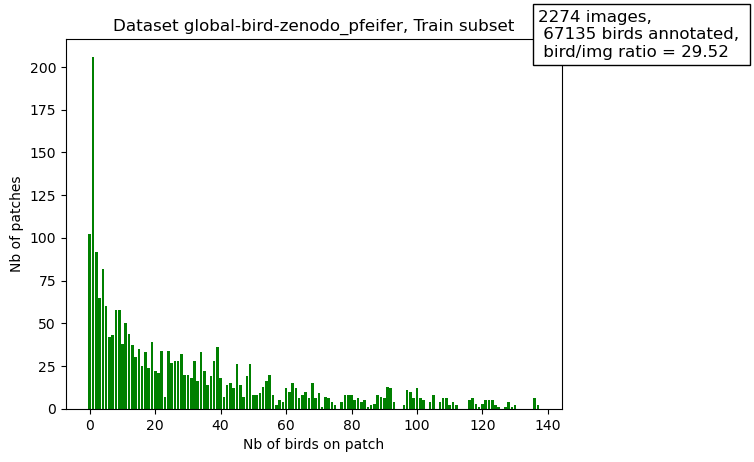

{1: 32, 2: 12, 3: 4, 4: 8, 5: 4, 6: 6, 7: 8, 8: 10, 9: 4, 10: 4, 12: 8, 13: 2, 14: 2, 15: 2, 16: 2, 23: 4, 30: 4, 35: 4, 37: 4, 40: 2, 41: 2, 44: 4, 55: 4, 58: 4, 65: 4, 70: 2, 71: 2, 79: 4, 102: 2, 103: 2, 115: 2, 117: 2}
343 160
nb of backgruond img in split:  183


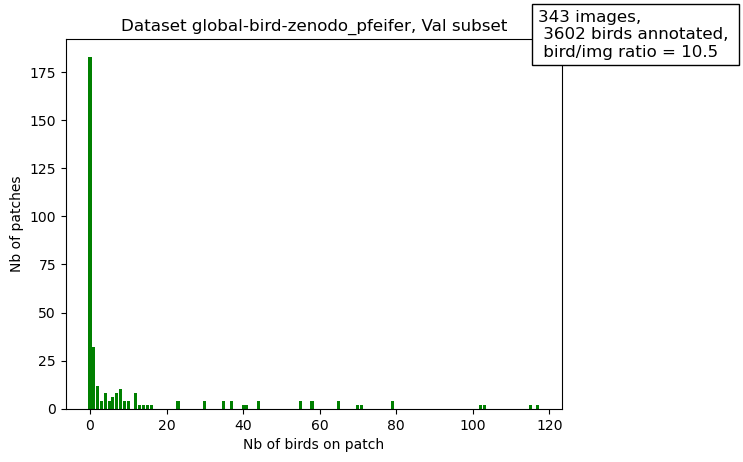

{1: 83, 2: 46, 3: 42, 4: 51, 5: 21, 6: 6, 7: 22, 8: 14, 9: 22, 10: 24, 11: 20, 12: 14, 13: 7, 14: 16, 15: 8, 16: 7, 17: 10, 18: 11, 19: 3, 20: 12, 21: 31, 22: 3, 24: 6, 25: 7, 26: 2, 27: 15, 28: 14, 29: 2, 30: 2, 31: 4, 32: 4, 33: 10, 34: 2, 35: 4, 36: 4, 38: 2, 39: 3, 40: 10, 41: 7, 42: 6, 43: 2, 44: 2, 46: 4, 47: 8, 48: 2, 49: 2, 50: 4, 52: 4, 57: 2, 58: 2, 59: 2, 60: 2, 61: 6, 62: 2, 63: 2, 64: 2, 67: 2, 68: 2, 70: 6, 71: 2, 78: 2, 79: 2, 80: 1, 81: 1, 82: 1, 83: 1, 86: 4, 88: 4, 94: 1, 95: 2, 96: 1, 97: 2, 98: 3, 99: 1, 100: 1, 101: 5, 102: 4, 111: 1, 112: 1, 113: 1, 114: 1}
727 677
nb of backgruond img in split:  50


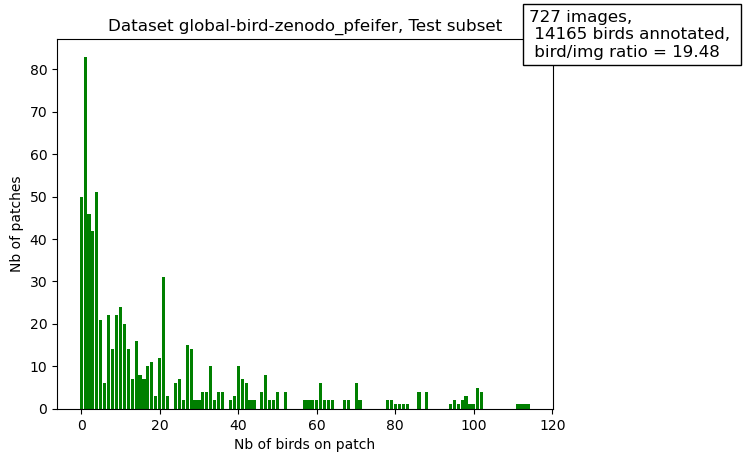

{1: 13, 2: 41, 3: 36, 4: 19, 5: 15, 6: 25, 7: 18, 8: 20, 9: 18, 10: 8, 11: 11, 12: 5, 13: 14, 14: 9, 15: 10, 16: 10, 17: 11, 18: 11, 19: 11, 20: 7, 21: 10, 22: 5, 23: 8, 24: 3, 25: 6, 26: 3, 27: 6, 28: 3, 29: 3, 30: 4, 32: 2, 33: 3, 34: 4, 35: 3, 36: 2, 37: 2, 38: 2, 39: 3, 40: 1, 41: 4, 43: 1, 44: 6, 45: 2, 46: 1, 47: 1, 49: 3, 50: 3, 51: 1, 52: 2, 53: 3, 54: 1, 55: 1, 57: 1, 59: 2, 60: 2, 61: 1, 62: 1, 63: 2, 65: 1, 66: 1, 68: 1, 72: 1, 73: 1, 83: 2, 84: 1, 96: 1}
485 432
nb of backgruond img in split:  53


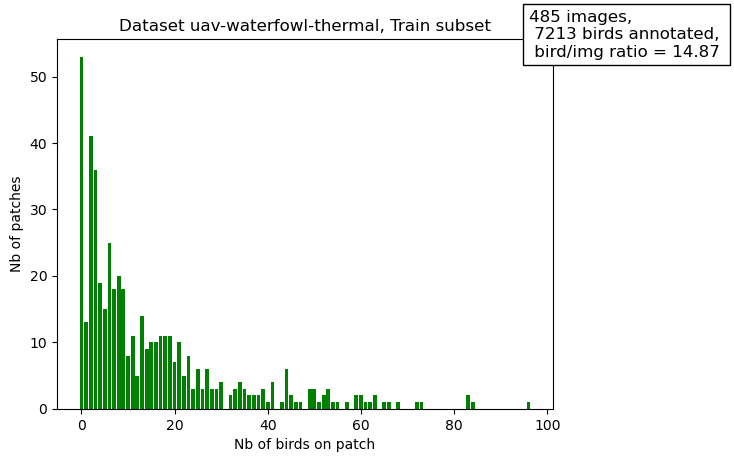

{1: 5, 2: 11, 3: 16, 4: 13, 5: 3, 6: 7, 7: 1, 8: 4, 9: 1, 10: 4, 11: 3, 12: 4, 13: 2, 14: 4, 15: 1, 16: 6, 17: 1, 18: 9, 19: 2, 20: 3, 21: 2, 22: 5, 23: 3, 25: 2, 26: 4, 27: 6, 28: 2, 29: 2, 30: 5, 31: 4, 32: 5, 33: 2, 34: 1, 36: 3, 37: 2, 38: 1, 39: 1, 41: 1, 42: 3, 43: 1, 48: 1, 51: 1, 55: 1, 58: 2, 59: 4, 61: 1, 66: 1, 70: 1, 72: 1, 75: 1, 76: 1, 78: 1, 79: 1, 81: 1, 83: 1, 84: 1, 86: 1, 87: 1, 88: 1, 91: 2, 92: 1, 106: 1, 108: 1, 111: 2, 113: 1, 116: 1, 118: 1, 122: 1, 126: 1, 137: 2, 138: 1, 139: 1}
206 194
nb of backgruond img in split:  12


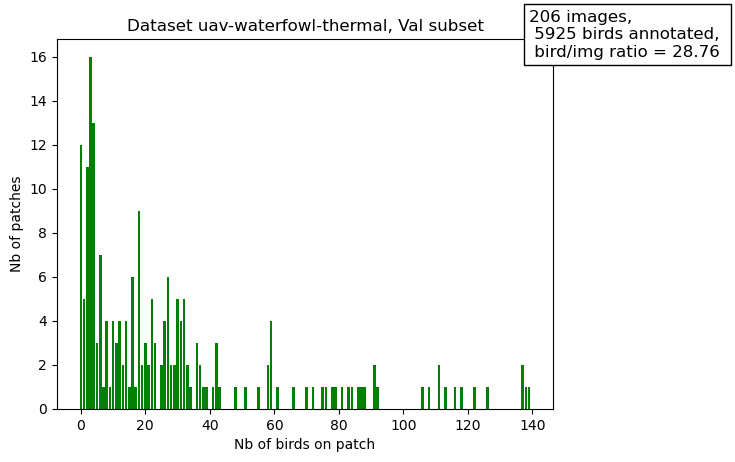

{2: 5, 3: 2, 4: 1, 5: 3, 6: 2, 7: 2, 8: 3, 9: 2, 10: 2, 11: 4, 12: 3, 13: 4, 14: 3, 15: 1, 18: 3, 19: 1, 20: 1, 22: 1, 24: 1, 25: 1, 27: 3, 28: 1, 29: 2, 31: 1, 32: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 42: 1, 44: 2, 45: 2, 48: 1, 49: 1, 61: 1, 64: 1, 68: 1}
83 70
nb of backgruond img in split:  13


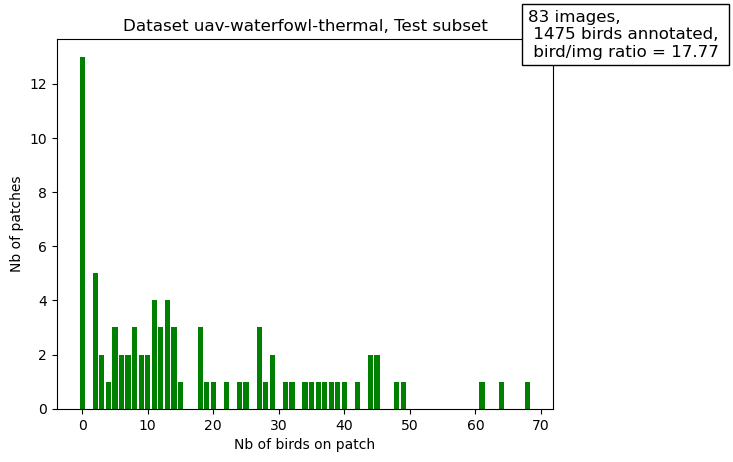

Nb of background images:  859
Total nb of images:  8724


In [6]:
# PER SPLITS

total_nb_bckgd_img = 0 
total_nb_img = 0 

for dataset in database1_source:

    dataset_stats = stats[dataset]

    for split in ['Train', 'Val', 'Test']:
        birds_repartition = dataset_stats[split]['birds_repartition']
        nb_birds = dataset_stats[split]['nb_birds']
        nb_img = dataset_stats[split]['nb_img']
        nb_background_img = nb_img - sum(birds_repartition.values())
        print("nb of backgruond img in split: ", nb_background_img)
        total_nb_bckgd_img += nb_background_img
        total_nb_img += nb_img
        birds_repartition[0] = nb_background_img
        bird_img_ratio = nb_birds/nb_img

        plt.bar(list(birds_repartition.keys()), birds_repartition.values(), color='g')
        plt.title(f'Dataset {dataset}, {split} subset')
        plt.text(max(birds_repartition.keys()), max(birds_repartition.values()), f"{nb_img} images, \n {nb_birds} birds annotated, \n bird/img ratio = {str(round(bird_img_ratio, 2))} ", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
        plt.xlabel('Nb of birds on patch')
        plt.ylabel('Nb of patches')
        plt.show()
        #plt.savefig(os.path.join(exploration_folder, f"stat_{dataset}_split_{split}.png"))

print("Nb of background images: ", total_nb_bckgd_img)
print("Total nb of images: ", total_nb_img)

## **Datasets means & standard deviations computation**

In [3]:
##### PARAMS
device      = torch.device('cpu') 
num_workers = 4
batch_size  = 128
image_size  = 224


##### DATASET

class ImageData(Dataset):
    
    def __init__(self, img_list, directory):
        super().__init__()
        self.img_list  = img_list
        self.directory = directory
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        
        # import
        path  = os.path.join(self.directory, self.img_list[idx])
        image = cv2.imread(path, cv2.COLOR_BGR2RGB)

        if image is None:
            raise FileNotFoundError(self.directory)
            
        return image

In [6]:
#splits = ['train','val','test']
splits =  ['uav_thermal_waterfowl'] 
'''['global_birds_poland', 'global_birds_palmyra', 'global_birds_penguins',
                    'global_birds_mckellar', 'global_birds_newmexico', 
                    'global_birds_pfeifer', 'uav_thermal_waterfowl']
'''

for split in splits:
    # dataset
    dataset_path = '/gpfs/gibbs/project/jetz/eec42/data/formatted_data_10percent_background_'
    split_path = os.path.join('/gpfs/gibbs/project/jetz/eec42/data/formatted_data_10percent_background_/' + split + '/images')
    available_img = os.listdir(split_path)
    image_dataset = ImageData(img_list      = available_img,
                              directory     = split_path)

    # data loader
    image_loader = DataLoader(image_dataset, 
                            batch_size  = 128, #len(available_img), 
                            shuffle     = False, 
                            num_workers = num_workers,
                            pin_memory  = True)


    image_size = Image.open(os.path.join(split_path, available_img[0])).size[0]
    

    ####### COMPUTE MEAN / STD

    # placeholders
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for inputs in tqdm(image_loader):
        psum    += inputs.sum(axis        = [0, 1, 2])
        psum_sq += (inputs ** 2).sum(axis = [0, 1, 2])


    ####### FINAL CALCULATIONS

    # pixel count
    count = len(available_img) * image_size * image_size

    # mean and std
    total_mean = psum / count
    #print(psum_sq)
    #print(count)
    #print(psum_sq/count)
    #print(total_mean ** 2)
    #print((psum_sq / count) - (total_mean ** 2))
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(torch.abs(total_var))

    # output
    print('SPLIT: ', split)
    print('mean: '  + str(total_mean.mean()))
    print('std:  '  + str(total_std.mean()))

100%|██████████| 7/7 [00:01<00:00,  4.31it/s]

SPLIT:  uav_thermal_waterfowl
mean: tensor(106.1132)
std:  tensor(105.6112)


In [7]:
####### COMPUTE MEAN / STD

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs.sum(axis        = [0, 1, 2])
    psum_sq += (inputs ** 2).sum(axis = [0, 1, 2])


####### FINAL CALCULATIONS

# pixel count
count = len(available_img) * image_size * image_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

mean: tensor([106.1132, 106.1132, 106.1132])
std:  tensor([nan, nan, nan])


## **Visualization**

In [16]:
from preprocessing_utils import preview_few_images, extract_dataset_config, load_config

database1_source = ['global-bird-zenodo_poland', 'global-bird-zenodo_palmyra', 'global-bird-zenodo_penguins',
                    'global-bird-zenodo_mckellar', 'global-bird-zenodo_newmexico', 
                    'global-bird-zenodo_pfeifer'] #, 'uav-waterfowl-thermal']

database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/formatted_data_'
saving_path = r'/gpfs/gibbs/project/jetz/eec42/data/visualization'

In [17]:
YAML_PATH = r'/home/eec42/BirdDetector/src/data_preprocessing/source_datasets_config.yaml'
config = load_config(YAML_PATH)
category_name_to_id = {'bird': 0}

for dataset in database1_source:
    # Extract specific dataset config
    dataset_config = extract_dataset_config(config, dataset)
    dataset_folder = os.path.join(database_folder, dataset_config["name"])
    os.makedirs(os.path.join(saving_path, dataset_config["name"]))

    preview_few_images(dataset_config, dataset_folder, category_name_to_id, nb_display=10, saving_path=os.path.join(saving_path, dataset_config["name"]) + '/')
    

Datasets config read successful


## **Find mean size of bboxes per dataset**

In [18]:
from preprocessing_utils import preview_few_images, extract_dataset_config, load_config, preview_image
import glob 
from pathlib import Path
import math

database1_source = ['global-bird-zenodo_poland', 'global-bird-zenodo_palmyra', 'global-bird-zenodo_penguins',
                    'global-bird-zenodo_mckellar', 'global-bird-zenodo_newmexico', 
                    'global-bird-zenodo_pfeifer', 'uav-waterfowl-thermal']

database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/formatted_data_10percent_background_'

In [19]:
YAML_PATH = r'/home/eec42/BirdDetector/src/data_preprocessing/source_datasets_config.yaml'
config = load_config(YAML_PATH)
category_name_to_id = {'bird': 0}

for dataset in database1_source:

    sum_bbox_size = 0
    nb_bbox = 0

    # Extract specific dataset config
    dataset_config = extract_dataset_config(config, dataset)
    dataset_folder = os.path.join(database_folder, dataset_config["name"])

    to_search = '/labels/**/*' + '.txt' #dataset_config["image_extension"]
    available_images = glob.glob(dataset_folder + to_search, recursive=True)

    img_size = int(Path(available_images[0]).stem[-3:])

    for label in available_images:
        df = pd.read_csv(label, sep='\t', header=None, index_col=False)
        for irow, row in df.iterrows():  
            nb_bbox += 1
            sum_bbox_size += row[3]*row[4]*img_size*img_size
    
    mean_bbox_size = sum_bbox_size/nb_bbox
    print("Dataset: ", dataset)
    print("Mean bbox size: ", math.sqrt(mean_bbox_size))
    print("0.7 of bbox size:", mean_bbox_size*0.7)
    print("0.5 of bbox size:", mean_bbox_size*0.5)


Datasets config read successful
Dataset:  global-bird-zenodo_poland
Mean bbox size:  58.71415841880242
0.7 of bbox size: 2413.1466791797584
0.5 of bbox size: 1723.6761994141134
Dataset:  global-bird-zenodo_palmyra
Mean bbox size:  37.198093823409536
0.7 of bbox size: 968.5887288666248
0.5 of bbox size: 691.8490920475892
Dataset:  global-bird-zenodo_penguins
Mean bbox size:  15.471053453452788
0.7 of bbox size: 167.5474464717154
0.5 of bbox size: 119.67674747979672
Dataset:  global-bird-zenodo_mckellar
Mean bbox size:  47.91167897700808
0.7 of bbox size: 1606.8702876771144
0.5 of bbox size: 1147.764491197939
Dataset:  global-bird-zenodo_newmexico
Mean bbox size:  193.78445930122123
0.7 of bbox size: 26286.691666666662
0.5 of bbox size: 18776.208333333332
Dataset:  global-bird-zenodo_pfeifer
Mean bbox size:  24.79911160690004
0.7 of bbox size: 430.49715554403895
0.5 of bbox size: 307.49796824574213
Dataset:  uav-waterfowl-thermal
Mean bbox size:  6.987174317333591
0.7 of bbox size: 34.17

## Nb of background patch in formatted_Data

In [11]:
DATA_FOLDER = r'/gpfs/gibbs/project/jetz/eec42/data/formatted_data_'
DATASETS = ['global_birds_palmyra', 'global_birds_pfeifer',
            'global_birds_mckellar', 'global_birds_penguins', 
            'global_birds_poland', 'uav_thermal_waterfowl']

In [12]:
for dataset in DATASETS:
    DATASET_FOLDER = os.path.join(DATA_FOLDER, dataset)
    IMG_FOLDER = os.path.join(DATASET_FOLDER, "images")
    LABEL_FOLDER = os.path.join(DATASET_FOLDER, "labels")

    label_list = os.listdir(LABEL_FOLDER)
    img_list = os.listdir(IMG_FOLDER)

    print(f"Dataset {dataset}: {len(img_list) - len(label_list)} background images")


Dataset global_birds_palmyra: 2497 background images
Dataset global_birds_pfeifer: 375 background images
Dataset global_birds_mckellar: 740 background images
Dataset global_birds_penguins: 78 background images
Dataset global_birds_poland: 673 background images
Dataset uav_thermal_waterfowl: 388 background images
